# Homework 5 (100 points) CNNs, AEs, GANs

## Task 1 (70 points): CNNs

### Part 1 (20 points): Custom CNN
This step involves downloading, preparing, and visualizing your
dataset. Create a convolutional base using a common pattern: a stack of Conv and
MaxPooling layers. Depending on the problem and the dataset you must decide what
pattern you want to use (i.e., how many Conv layers and how many pooling layers).
Please describe why you chose a particular pattern. Add the final dense layer(s).
Compile and train the model. Report the final evaluation and describe the metrics

#### Dataset & Preparation

For this task I have selected the PlantVillage, plant leaf diseases dataset available [here](https://data.mendeley.com/datasets/tywbtsjrjv/1) and [here](https://paperswithcode.com/dataset/plantvillage). The dataset contains images of different types of plants with and without various diseases. I have dumbed down the dataset to bbe 

In [1]:
import os

import torch
import torch.utils.data
import torchvision.io
import torchvision.transforms

class PlantVillageDataset(torch.utils.data.Dataset):
    def __init__(self):
        base_path = "data/PlantVillageDataset"
        self.images = [] #list of all image classes with their paths in a tuple (class_ohe, image path)
        self.image_classes = os.listdir(base_path)
        self.resize = torchvision.transforms.Resize((64, 64))
        for i, image_class in enumerate(self.image_classes):
            #image_class_ohe = torch.tensor([1 if j == i else 0 for j in range(len(self.image_classes))]) #one hot encoding for the class label
            image_names = os.listdir(f"{base_path}/{image_class}")
            for image_name in image_names:
                image_tensor = self.resize(torchvision.io.read_image(f"{base_path}/{image_class}/{image_name}"))/255
                self.images.append((image_tensor, i))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.images[index]

dataset = PlantVillageDataset()

torch.Size([3, 64, 64])
0


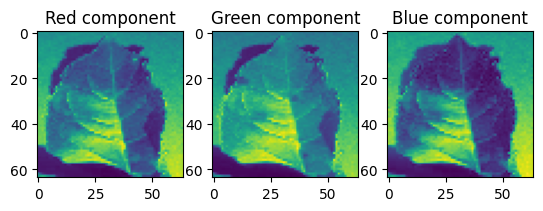

In [73]:
import matplotlib.pyplot as plt

print(dataset[10][0].shape)
print(dataset[10][1])

fig, ax = plt.subplots(ncols=3)
ax[0].set_title("Red component")
ax[0].imshow(dataset[10][0][0])
ax[1].set_title("Green component")
ax[1].imshow(dataset[10][0][1])
ax[2].set_title("Blue component")
ax[2].imshow(dataset[10][0][2])

We see that each image is composed of 3 color planes with a width and height of 64. We observe 4 classes in total. next we inspect the class distribution of the dataset. Due to the relatively even distribution of the classes we will use classification accuracy as our metric.

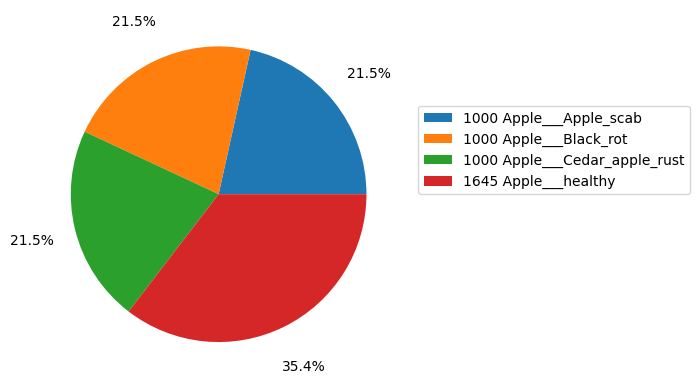

In [72]:
import numpy as np

def class_pie(dataset):
    class_indexes = [x[1] for x in dataset.images]
    class_counts = np.unique(class_indexes, return_counts=True)
    plt.pie(x=class_counts[1], autopct='%1.1f%%', pctdistance=1.3);
    plt.legend(labels=[str(class_counts[1][i]) + " " + dataset.image_classes[i] for i in range(len(class_counts[1]))], loc=(1.04, 0.5))

class_pie(dataset)

In [37]:
train_percent = 0.9
train_count = int(train_percent*len(dataset))
split_lengths = [train_count, len(dataset) - train_count]

train_dataset, test_dataset = torch.utils.data.random_split(dataset, split_lengths)

#### Custom CNN

In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix

def as_tensors(dataset):
    return next(iter(torch.utils.data.DataLoader(dataset, batch_size=len(dataset))))

#predict the binary classes from X when fed through the model
def predict(model, X):
    model_outputs = model(X)
    predicted_classes = torch.argmax(model_outputs, dim=1)
    return predicted_classes

def print_accuracy_dataset(name, model, X, y):
    y_prime = predict(model, X)
    f1 = accuracy_score(y.detach().numpy(), y_prime.detach().numpy())
    print("Accuracy Score for {}: {:0.2f}%".format(name, f1*100))

In [69]:
import torch.nn
import torch.optim
import torch.utils.data

#hyperparameters
epochs = 30
batch_size = 128
optimizer = torch.optim.Adam
lossFunction = torch.nn.CrossEntropyLoss()

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [67]:
from ipywidgets import IntProgress
from IPython.display import display
import seaborn as sns

def train_cnn_model(model):
    progress_bar = IntProgress(min=0, max=epochs*(len(dataset)//batch_size)) # instantiate the bar
    display(progress_bar) # display the bar
    model_optimizer = optimizer(model.parameters())
    losses = []
    print("Epochs: ")
    for epoch in range(epochs):
        print(str(epoch) + ",", end="")
        for X, y in train_dataloader:
            model_outputs = model(X)
            batch_cost = lossFunction(model_outputs, y)
            losses.append(batch_cost)
            model_optimizer.zero_grad()
            batch_cost.backward()
            model_optimizer.step()
            progress_bar.value += 1
    print("\b\n")
    print_accuracy_dataset("Training", model, *as_tensors(train_dataset))
    print_accuracy_dataset("Testing", model, *as_tensors(test_dataset))
    fig, ax = plt.subplots(nrows=2, figsize=(5,10)) 
    ax[0].set_title("Loss vs Time")
    ax[0].set_xlabel("Loss")
    ax[0].set_ylabel("Time")
    ax[0].plot(losses)
    x_test, y_test = as_tensors(train_dataset)
    test_confusion_matrix = confusion_matrix(y_test, predict(model, x_test).detach().numpy())
    ax[1].set_title("Testing Confusion Matrix")
    sns.heatmap(test_confusion_matrix, ax=ax[1], annot=True, cmap='RdYlGn', fmt='d')

For my model I select a basic convilutional scheme that uses a Conv2d layer, with 3 input features, a 5x5 kernel, and stride of 1 followed by a MaxPool layer with a kernel and stride of 2. Due to the simple nature of the dataset I start with 10 output features for this layer rather than going for something big. The 3 input features correspond to the RGB planes of the image. The Max pool 2d layer effectively reduces the dimensionality by half. For the next section I repeat with another convilutional layer with 20 output features followed max pool before flattening. The flattening gets the convilutional layer this time is much smaller so we have more potential high level features for the dense layers. For my dense layers I used two linear layers with no activation on the output so that I could use CrossEntropyLoss effectively as this is a binary classification task. The reason I selected this architecture was because it is similar to the LeNet architecture which despite being old, is now a very shallow network that works well for simple tasks like this an MNIST. One of the main reasons I selected this layout was that it didn't take too long to run on my machine.

IntProgress(value=0, max=1080)

Epochs: 
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29

Accuracy Score for Training: 95.91%
Accuracy Score for Testing: 91.83%


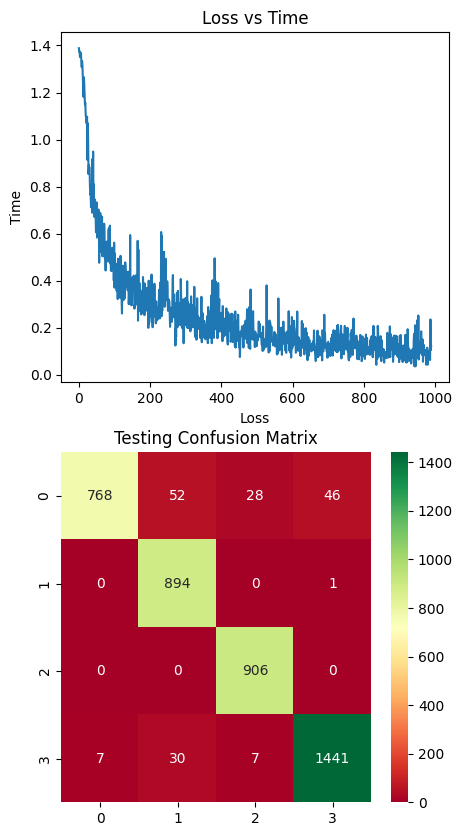

In [71]:
conv_model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 10, 5),  
    torch.nn.ReLU(), 
    torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(10, 20, 5),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(4, 4),
    torch.nn.Flatten()
)

fully_connected_model = torch.nn.Sequential(
    torch.nn.Linear(720, 300),
    torch.nn.ReLU(),
    torch.nn.Linear(300, len(dataset.image_classes))
)

model = torch.nn.Sequential(conv_model, fully_connected_model)

train_cnn_model(model)

I chose to use accuracy to evaluate my model for two reasons. The first is that there are similar class breakdowns for the 3 classes, the second is that false positives don't affect us greatly, but compose the bulk of our miss-classifications (many more than false negatives) which have greater implications for this task. The model preforms quite well with ~95% accuracy on the training set and ~90% on the testing set. We observe good convergence in the loss vs time graph. In the confusion matrix we see that we have many more false positives then negatives. This is desireable as in real life false positives on this task would just involve spraying the apple tree with medicine it didn't need. 

### Part 2 (25 points): Using popular models
The following models are widely used for transfer learning because of
their performance and architectural innovations:
1. VGG (e.g., VGG16 or VGG19).
2. GoogLeNet (e.g., InceptionV3).
3. Residual Network (e.g., ResNet50).
4. MobileNet (e.g., MobileNetV2)
Choose any one of the above models to perform the classification task you did in Part 1.
Evaluate the results using the same metrics as in Part 1. Are there any differences? Why
or why not?

#### Learning With VGG11

I choose to use and evaluate the VGG11 model for my transfer learning task, unfortunately when I tried transfer learning with the pretrained version of it it, my computer ran out of memory and crashed, hence I recreate it here

In [84]:
import torchvision.models

vgg11 = torchvision.models.vgg11()

fully_connected_model = torch.nn.Sequential(
    torch.nn.Linear(1000, 300),
    torch.nn.ReLU(),
    torch.nn.Linear(300, len(dataset.image_classes))
)

model = torch.nn.Sequential(vgg11, fully_connected_model)

epochs = 5
batch_size = 256

train_cnn_model(model)

IntProgress(value=0, max=90)

Epochs: 
0,1,2,3,4

